# Convert building polygons to building masks for semantic segmentation model

*Written by: Men Vuthy, 2022*

---





You can also run the code here in Google Colab. Try clicking button below:

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/15r0FWj7GsWTL0n_Km5Ux26_AKNcajU7k#scrollTo=62OiCG_SB6jU)

Normally, the mask for deep learning model take form as ``.png``, ``.jpg`` or  ``.tiff`` file format. In our case model, we need a mask in ``.tiff`` format; thus, it is necessary to convert our building footprint polygons from ``.shp`` to ``.tiff`` file as following form:

*   3 bands (B1, B2, B3)
*   Building (255, 255, 255), and Non-building (0, 0, 0)




### Objective


*   Convert one mask from shapefile to geotiff
*   Convert multiple masks in a directory from shapefile to geotiff

### Dataset



### Code

Install necessary modules

In [1]:
!pip install rasterio
!pip install geopandas

**1. Convert one mask image**

Import necessary modules

In [2]:
import os
import glob
import rasterio
import geopandas as gpd
import numpy as np
import fiona
from rasterio.plot import show
from rasterio.mask import mask
import matplotlib.pyplot as plt
%matplotlib inline 

Import input dataset

In [3]:
# Import image as for polygon reference
image = rasterio.open('/content/drive/MyDrive/Colab Notebooks/Porfolio/Deep-learning/data/image/8-byte image/image001.tiff')

In [4]:
# Import building foorprint polygon
bldg_poly = gpd.read_file('/content/drive/MyDrive/Colab Notebooks/Porfolio/Deep-learning/data/footprint/image001.shp')

Visualize the image and building shape

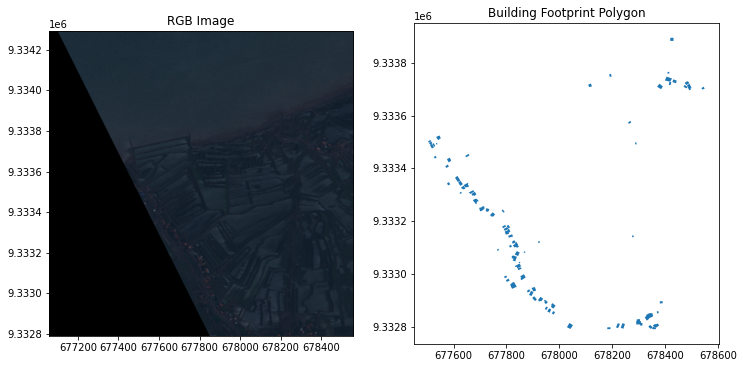

In [5]:
# Create subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

# Plot RGB image
show(image, ax=ax1)
ax1.set_title('RGB Image')

# Plot building footprint
bldg_poly.plot(ax=ax2)
ax2.set_title('Building Footprint Polygon')

plt.show();

Next, we will clip raster image with the building polygon using ``fiona`` module.

In [6]:
# Read Shape file
with fiona.open('/content/drive/MyDrive/Colab Notebooks/Porfolio/Deep-learning/data/footprint/image001.shp', "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

    # Filter NoneType from building shape
    shapes = list(filter(None, shapes))

In [7]:
# Clip the raster with Polygon
out_img, out_transform = mask(image, shapes, crop=False)

Change all raster value that are within building polygon to 255.

In [8]:
# Set unique value on mask area
out_img_unique = np.where(out_img!= 0, 255, out_img)


Create 3 bands with the datatype of 8-byte or uint8

In [9]:
# Create mask composite by stacking
mask = np.dstack((out_img_unique[0], out_img_unique[1], out_img_unique[2])).astype('uint8')

print(mask.shape)

(3000, 3000, 3)


Visualize the RGB image and building mask

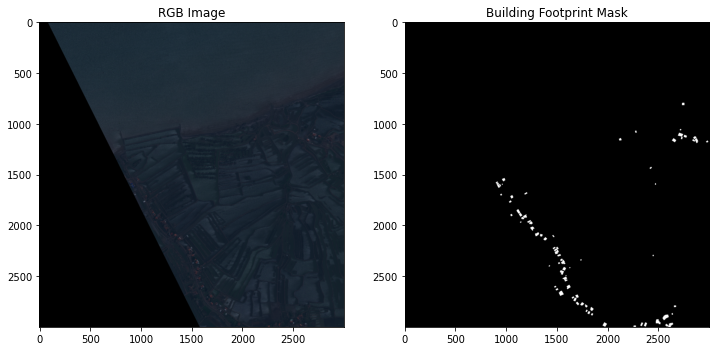

In [10]:
# Create subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

# Plot RGB image
ax1.imshow(image.read().transpose(1, 2, 0))
ax1.set_title('RGB Image')

# Plot building footprint
ax2.imshow(mask)
ax2.set_title('Building Footprint Mask')

plt.show();

Export mask to ``.tiff`` file

In [11]:
# Transpose the mask shape
mask_transpose = mask.transpose(2, 0, 1)

print(mask_transpose.shape)

(3, 3000, 3000)


In [12]:
# Data dir
data_dir = "/content/drive/MyDrive/Colab Notebooks/Porfolio/Deep-learning/data/mask"

# Output raster
out_tif = os.path.join(data_dir, "image001.tiff")

# Copy the metadata
out_meta = image.meta.copy()

out_meta.update({"driver": "GTiff",
                 "dtype": 'uint8',
                 "height": out_img.shape[1],
                 "width": out_img.shape[2],
                 "transform": out_transform,
                 "count": 3,
                 "crs": image.crs})

In [13]:
with rasterio.open(out_tif, "w", **out_meta) as dest:
        dest.write(mask_transpose.astype('uint8'))

**2. Convert multi-mask images**




Import necessary modules

In [14]:
import os
import glob
import rasterio
import geopandas as gpd
import numpy as np
import fiona
from rasterio.plot import show
from rasterio.mask import mask
import matplotlib.pyplot as plt
%matplotlib inline 

Create filepath of each image file in the directory

In [15]:
# File and folder paths
directory = '/content/drive/MyDrive/Colab Notebooks/Porfolio/Deep-learning/data/image/8-byte images/'

# Make a search criteria to select the raster files
search_criteria = "image*.tiff"

# File path
filepaths = os.path.join(directory, search_criteria)

# glob function can be used to list files from a directory with specific criteria
images = sorted(glob.glob(filepaths))

# Files that were found:
images

['/content/drive/MyDrive/Colab Notebooks/Porfolio/Deep-learning/data/image/8-byte images/image001.tiff',
 '/content/drive/MyDrive/Colab Notebooks/Porfolio/Deep-learning/data/image/8-byte images/image002.tiff',
 '/content/drive/MyDrive/Colab Notebooks/Porfolio/Deep-learning/data/image/8-byte images/image003.tiff',
 '/content/drive/MyDrive/Colab Notebooks/Porfolio/Deep-learning/data/image/8-byte images/image004.tiff',
 '/content/drive/MyDrive/Colab Notebooks/Porfolio/Deep-learning/data/image/8-byte images/image005.tiff',
 '/content/drive/MyDrive/Colab Notebooks/Porfolio/Deep-learning/data/image/8-byte images/image006.tiff']

Read all images from filepath

In [16]:
# Create a list of images
source_images = []

for image in images:
  img = rasterio.open(image)
  source_images.append(img)

source_images

[<open DatasetReader name='/content/drive/MyDrive/Colab Notebooks/Porfolio/Deep-learning/data/image/8-byte images/image001.tiff' mode='r'>,
 <open DatasetReader name='/content/drive/MyDrive/Colab Notebooks/Porfolio/Deep-learning/data/image/8-byte images/image002.tiff' mode='r'>,
 <open DatasetReader name='/content/drive/MyDrive/Colab Notebooks/Porfolio/Deep-learning/data/image/8-byte images/image003.tiff' mode='r'>,
 <open DatasetReader name='/content/drive/MyDrive/Colab Notebooks/Porfolio/Deep-learning/data/image/8-byte images/image004.tiff' mode='r'>,
 <open DatasetReader name='/content/drive/MyDrive/Colab Notebooks/Porfolio/Deep-learning/data/image/8-byte images/image005.tiff' mode='r'>,
 <open DatasetReader name='/content/drive/MyDrive/Colab Notebooks/Porfolio/Deep-learning/data/image/8-byte images/image006.tiff' mode='r'>]

Create filepath of each shapefile in the directory

In [17]:
# File and folder paths
directory = '/content/drive/MyDrive/Colab Notebooks/Porfolio/Deep-learning/data/footprint/'

# Make a search criteria to select the shape files
search_criteria = "image*.shp"

# File path
filepaths = os.path.join(directory, search_criteria)

# glob function can be used to list files from a directory with specific criteria
shapes = sorted(glob.glob(filepaths))

# Files that were found:
shapes

['/content/drive/MyDrive/Colab Notebooks/Porfolio/Deep-learning/data/footprint/image001.shp',
 '/content/drive/MyDrive/Colab Notebooks/Porfolio/Deep-learning/data/footprint/image002.shp',
 '/content/drive/MyDrive/Colab Notebooks/Porfolio/Deep-learning/data/footprint/image003.shp',
 '/content/drive/MyDrive/Colab Notebooks/Porfolio/Deep-learning/data/footprint/image004.shp',
 '/content/drive/MyDrive/Colab Notebooks/Porfolio/Deep-learning/data/footprint/image005.shp',
 '/content/drive/MyDrive/Colab Notebooks/Porfolio/Deep-learning/data/footprint/image006.shp']

Create a list of geometry of all shapefiles

In [18]:
# Create a list of images
source_shape = []

for shape in shapes:
  with fiona.open(shape, "r") as shapefile:
    shp = [feature["geometry"] for feature in shapefile]
    shp = list(filter(None, shp))
  source_shape.append(shp)

Based on the geometry of each shapefile, we can clip all raster images.

In [19]:
# Clip image and set unique value on mask area
out_image, out_transforms = [],[]

for i in range(len(source_images)):
  # Clip the raster with Polygon
  out_img, out_transform = mask(source_images[i], source_shape[i], crop=False)
  # Set unique value on mask area
  out_img_unique = np.where(out_img!= 0, 255, out_img)
  # Append to list
  out_image.append(out_img_unique)
  out_transforms.append(out_transform)

Create masks and transpose them for export

In [20]:
# Create mask
mask = []
mask_transpose = []

for i in range(len(out_image)):
  mask_img = np.dstack((out_image[i][0], out_image[i][1], out_image[i][2])).astype('uint8')
  mask.append(mask_img)
  # Transpose mask
  transpose = mask_img.transpose(2, 0, 1)
  mask_transpose.append(transpose)


Visualize the RGB images and masks

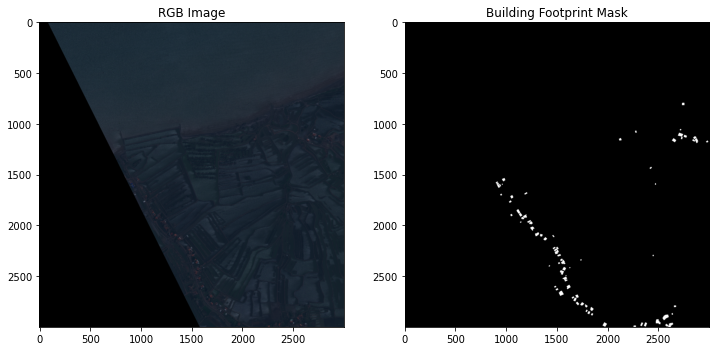

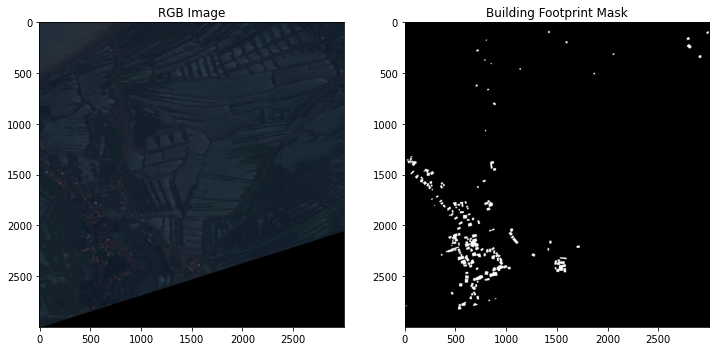

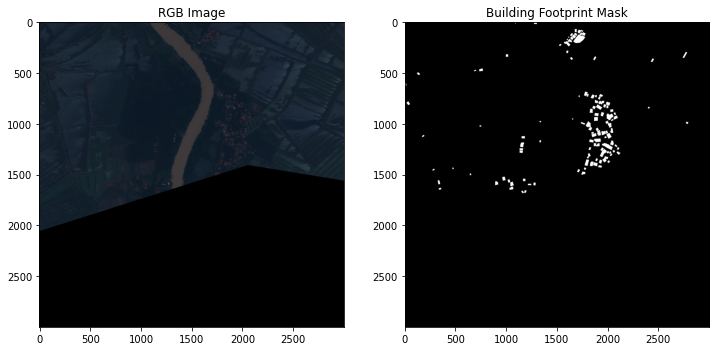

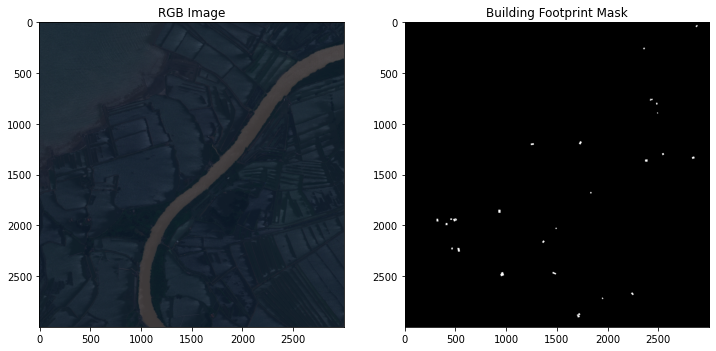

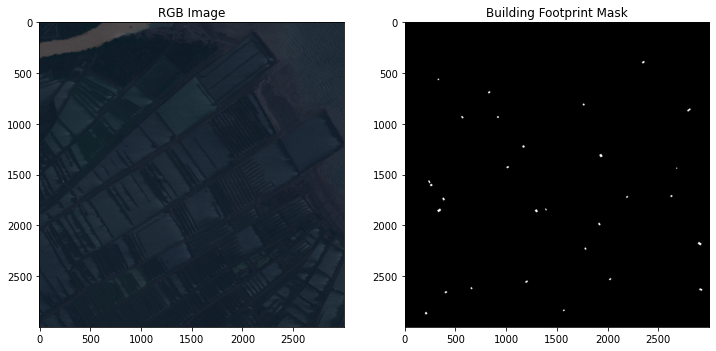

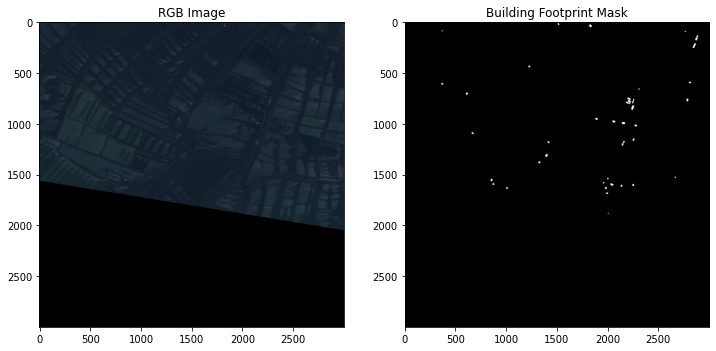

In [21]:
for i in range(len(source_images)):
  # Create subplot
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

  # Plot RGB image
  ax1.imshow(source_images[i].read().transpose(1, 2, 0))
  ax1.set_title('RGB Image')

  # Plot building footprint
  ax2.imshow(mask[i])
  ax2.set_title('Building Footprint Mask')

  plt.show();

Confirm the file name before writing image to tiff file

In [22]:
for i in range(len(images)):
  # File name
  name = images[i].split('/', -1)[10]
  print(name)

image001.tiff
image002.tiff
image003.tiff
image004.tiff
image005.tiff
image006.tiff


In [23]:
for i in range(len(images)):
  # File name
  name = images[i].split('/', -1)[10]
  
  # Data dir
  data_dir = "/content/drive/MyDrive/Colab Notebooks/Porfolio/Deep-learning/data/mask/"

  # Output raster
  out_tif = os.path.join(data_dir, name)

  # Copy the metadata
  out_meta = source_images[i].meta.copy()

  # update meta
  out_meta.update({"driver": "GTiff",
                 "dtype": 'uint8',
                 "height": mask_transpose[i].shape[1],
                 "width": mask_transpose[i].shape[2],
                 "transform": out_transforms[i],
                 "count": 3,
                 "crs": source_images[i].crs})
  
  # Write image to tiff file
  with rasterio.open(out_tif, "w", **out_meta) as dest:
        dest.write(mask_transpose[i].astype('uint8'))

Finally, we can see how to convert building polygons to building masks for semantic segmentation model.

---
